In [1]:
%load_ext autoreload

# Import

In [5]:
%autoreload 

# Setup right folder path
from os.path import abspath
from sys import path
path.append(abspath('../../'))

from preprocessing.functions import *
from functions import *

# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn part
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
# from sklearn.metrics import mean_squared_log_error
# from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LinearRegression

# other models
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

# others
# from scipy.stats import uniform, randint

In [6]:
SEED = 42

# Pipeline 

In [7]:
df_train = pd.read_csv("../../data/stores_train.csv")
df_test = pd.read_csv("../../data/stores_test.csv")

df_train = remove_outliers(df_train)
df_train = fix_lat_lon(df_train)
df_test = fix_lat_lon(df_test)

X_train, X_test, Y_train, scaler_revenue = features_engineering(df_train, df_test)

**WARING**

I've done the first feature analysis selection without scaling the data cause it's not working with -1

But for the selection with the model, it's probably better to use the scaling

To modify this -> Go to features_engineering/functions.py and comment/uncomment the last lines with the scaling

# Analysis
## Univariate Selection

Select the best features with the sklearn function

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

NUMBER_FEATURES = 12

for tmp in [f_regression, mutual_info_regression]:
    print('-------------------------------------------------------------------')
    bestfeatures = SelectKBest(score_func=tmp, k=NUMBER_FEATURES)
    fit = bestfeatures.fit(X_train, np.ravel(Y_train))
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X_train.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    print(featureScores.nlargest(NUMBER_FEATURES,'Score')) 

-------------------------------------------------------------------
                                      Specs        Score
39                       encoded_chain_name  1304.775204
41                         encoded_lv3_desc   180.340481
3                                     SI_p1    93.445357
4                                     SI_p2    80.397692
40               encoded_sales_channel_name    74.516686
38                        encoded_mall_name    17.040274
5                                     SI_p3    15.642697
11  hp_single_parent_children_6_to_17_years    15.286217
15                               ih_singles    13.537298
8            hp_couple_children_18_or_above    13.366226
7          hp_couple_children_6_to_17_years    13.081691
10   hp_single_parent_children_0_to_5_years    10.504852
-------------------------------------------------------------------
                                    Specs     Score
40             encoded_sales_channel_name  0.224193
41                 

Information gain, evaluation the information gain of each variable in the context of the target variable

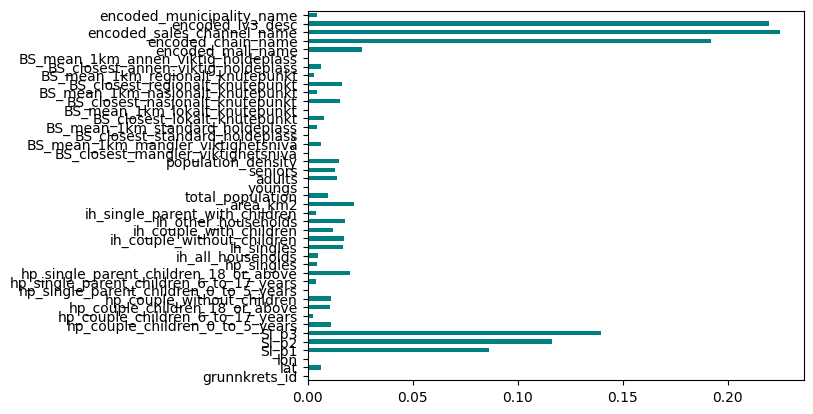

In [9]:
from sklearn.feature_selection import mutual_info_classif

importances = mutual_info_regression(X_train, np.ravel(Y_train))
feat_importances = pd.Series(importances, X_train.columns)
feat_importances.plot(kind='barh', color='teal')
plt.show()

Feature with higher variance may contain more useful information

In [10]:
from sklearn.feature_selection import VarianceThreshold

v_threshold = VarianceThreshold(threshold=0)
v_threshold.fit(X_train)
v_threshold.get_support()
# all features have variance

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

Mean Absolute Difference, the higher the MAD is, the higher is discriminatory power

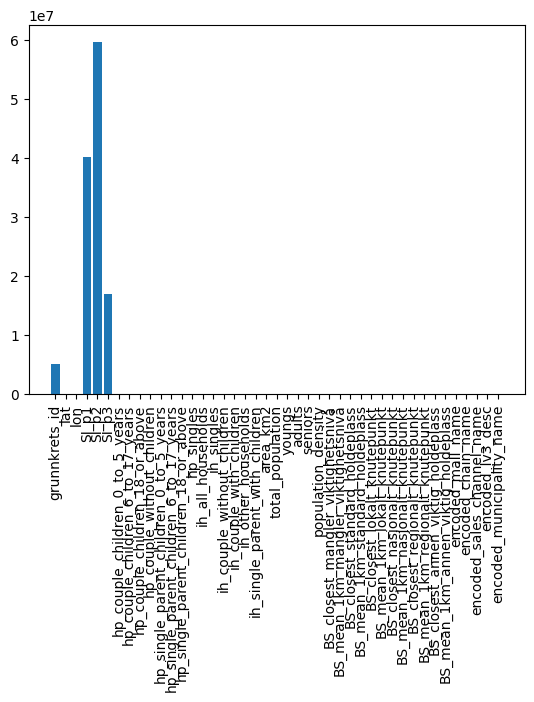

In [11]:
mean_abs_diff = np.sum(np.abs(X_train - np.mean(X_train, axis=0)), axis=0)/X_train.shape[0]
plt.bar(X_train.columns, mean_abs_diff)
plt.xticks(rotation = 90)
plt.show()

Dispersion ratio, the higher it is, the more relevant the feature is

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


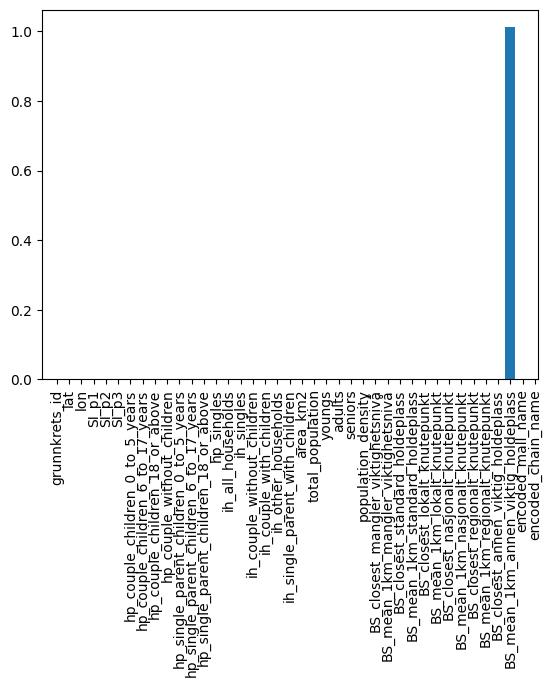

In [12]:
X = X_train + 1
am = np.mean(X, axis=0)
gm = np.power(np.prod(X, axis=0), 1/X.shape[0])
disp_ratio = am/gm
plt.bar(X.columns, disp_ratio)
plt.xticks(rotation = 90)
plt.show()

## Feature importance

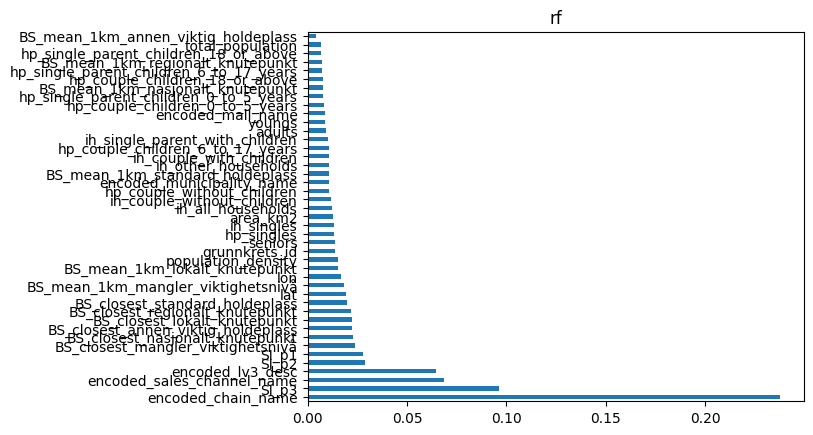

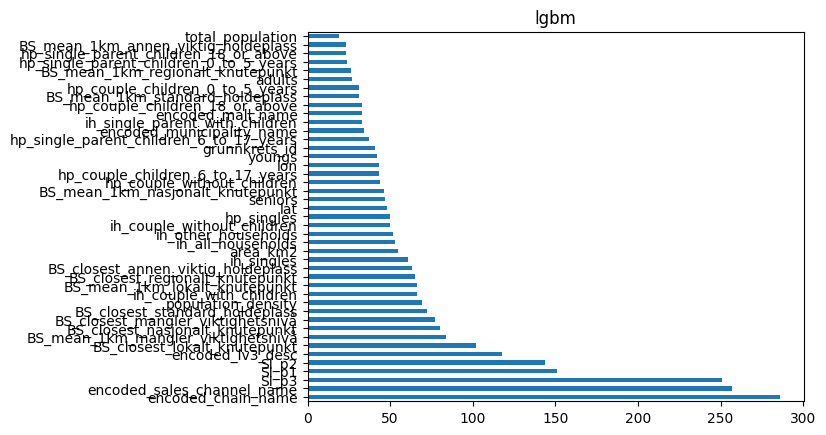

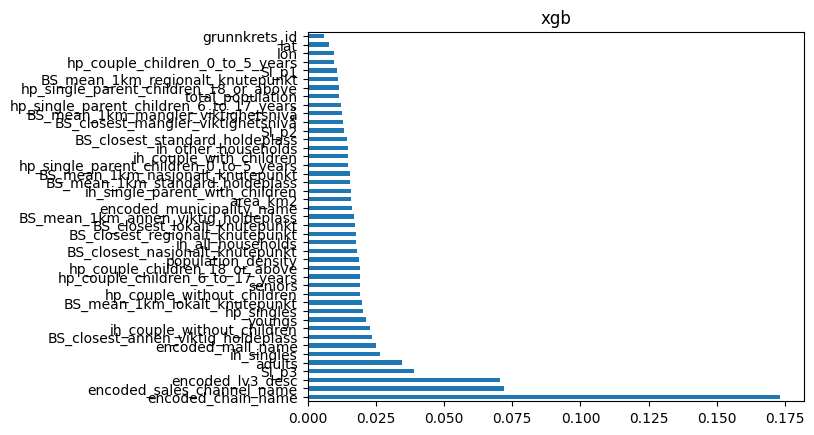

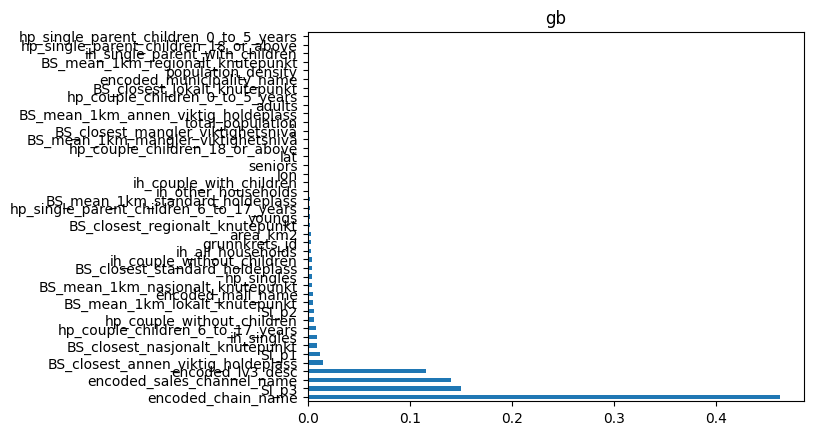

C:\Users\thepy\AppData\Local\Programs\Python\Python310\lib\site-packages\catboost\core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


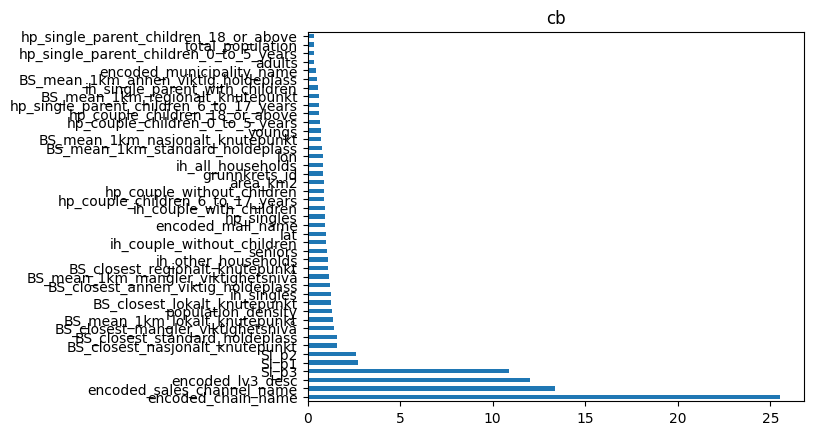

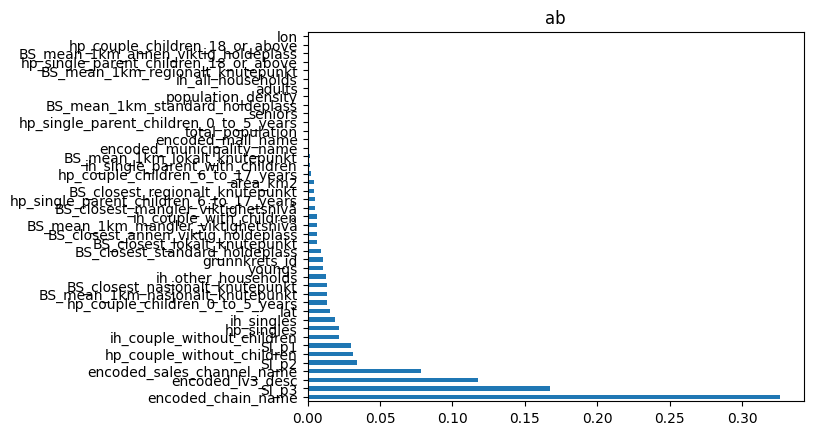

In [15]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

models = {
    'rf': RandomForestRegressor(random_state=SEED,),
    'lgbm': LGBMRegressor(),
    'xgb': XGBRegressor(random_state=SEED,),
    'gb': GradientBoostingRegressor(random_state=SEED,),
    'cb': CatBoostRegressor(random_state=SEED, silent=True),
    'ab': AdaBoostRegressor(random_state=SEED,),
}

for key in models:
    plt.title(key)
    model = models[key]
    model.fit(X_train, np.ravel(Y_train))
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(X_train.shape[0]).plot(kind='barh')
    plt.show()

## Correlation Matrix with Heatmap

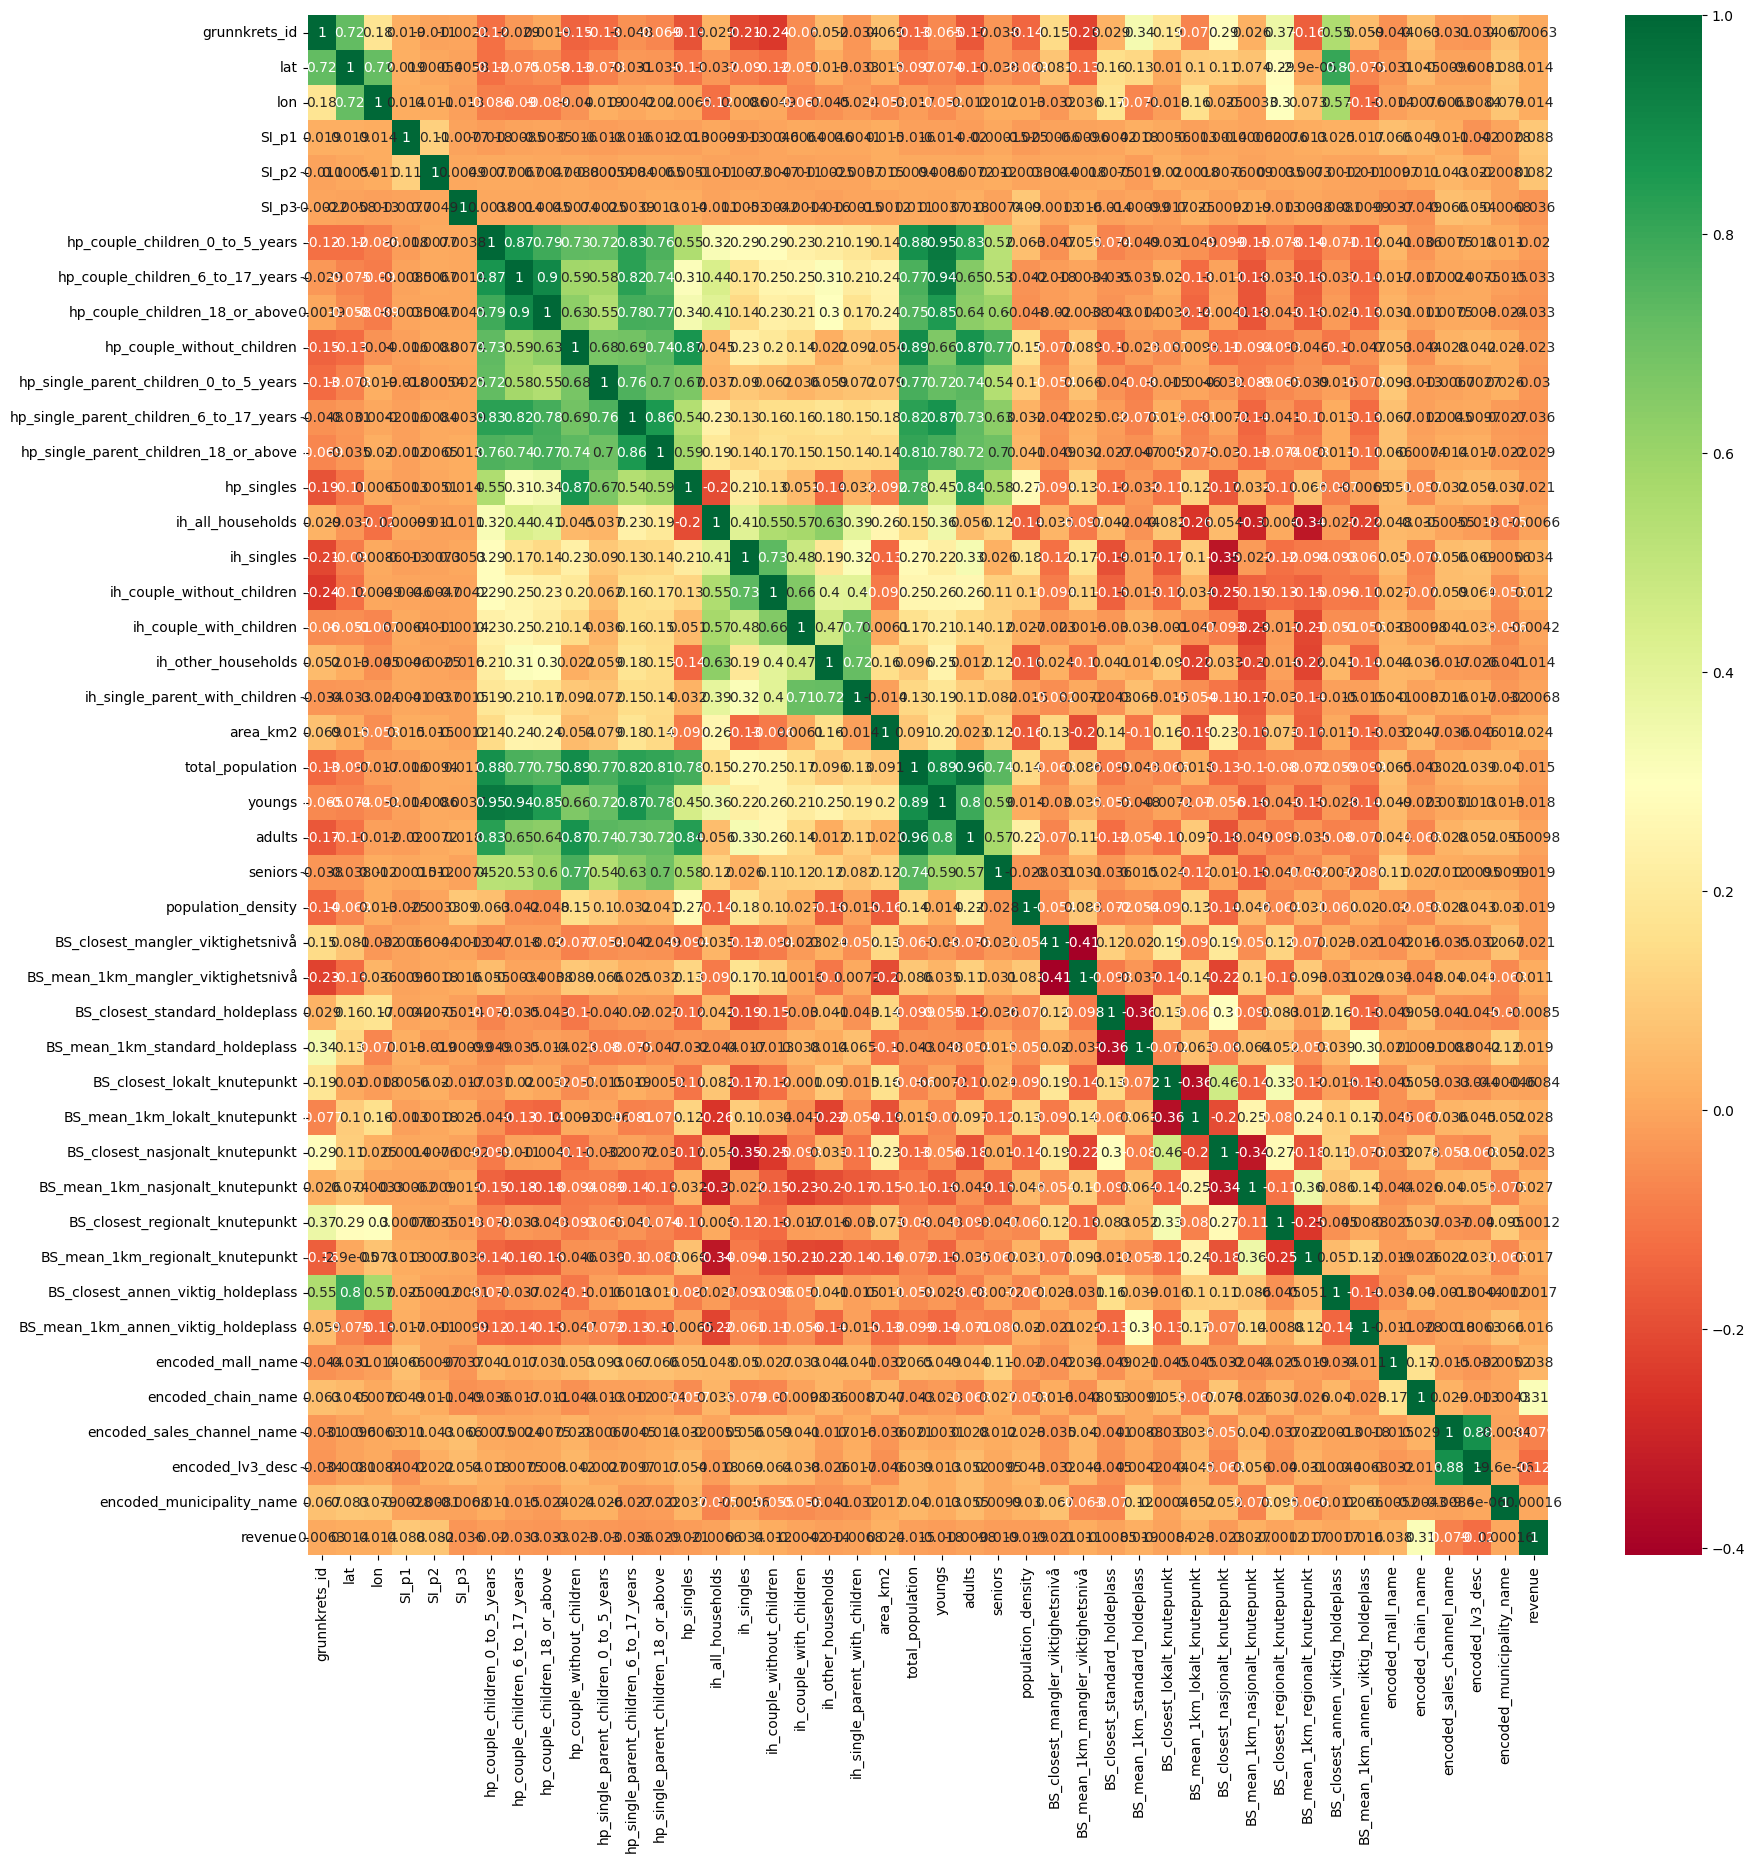

In [14]:
data = X_train.copy()
data['revenue'] = Y_train
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Exhaustive Feature Selection

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

# IMPORT MODEL TO EVALUATE WITH FEATURES
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


models = {
    'rf': RandomForestRegressor(random_state=SEED,),
    'lgbm': LGBMRegressor(),
    'xgb': XGBRegressor(random_state=SEED,),
    'gb': GradientBoostingRegressor(random_state=SEED,),
    'cb': CatBoostRegressor(random_state=SEED, silent=True),
    'ab': AdaBoostRegressor(random_state=SEED,),
}

for key in models:
    print(key)
    model = models[key]
    efs = ExhaustiveFeatureSelector(model,
                                   min_features=4,
                                   max_features=8,
                                   scoring='neg_mean_squared_error',
                                   cv=2
                                   )
    efs = efs.fit(X_train, np.ravel(Y_train))

    selected_features = X_train.columns[list(efs.best_idx_)]
    print(selected_features)
    print(efs.best_score)